# Crop yield estimation and analysis

This notebook generates yield estimates from the imagery that we downloaded and processed in `01-get-process-data` and compares the results to the crop cut data obtained from Radiant MLHub. 

The results are quite poor. This may be due to weaknesses in the remote sensing methods used in this training. For instance, the cloud mask is not perfect and the generation of yield measurements from the panel data set of vegetation index values generated by calculating zonal statistics could be improved. The purpose of this notebook is to show how one may calculate VI values. As a result, more effort is not put into creating accurate estimates. However, more attention should be given to these issues if you wish to use the satellite measurements for purposes other than learning. 

It is also possible that limitations of the plot boundary or crop cut data are driving the poor results. The data set is not particularly well optimized for satellite yield measurements because it spans a very large area and multiple Sentinel-2 swaths. The crop cut or plot boundary data may also be inaccurate. 

Despite these limitations, the data set is useful for illustrating the key methods of vegetation index calculation using multispectral imagery. 

# Generate Vegetation Indices

In [1]:
from osgeo import gdal 
from osgeo import gdalconst
import os
import rasterio
import numpy
import itertools
import glob
import multiprocessing
from skimage.transform import resize
import tempfile


# Function to downsample imagery (e.g. from 10m to 20m)
def downsample(inputfile, referencefile):
    input = gdal.Open(inputfile, gdalconst.GA_ReadOnly)
    inputProj = input.GetProjection()
    inputTrans = input.GetGeoTransform()

    reference = gdal.Open(referencefile, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    bandreference = reference.GetRasterBand(1)    
    x = reference.RasterXSize 
    y = reference.RasterYSize

    tmp = tempfile.NamedTemporaryFile(suffix='.tif', delete=False)
    tmp.close()

    driver= gdal.GetDriverByName('GTiff')
    output = driver.Create(tmp.name, x, y, 1, bandreference.DataType)
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)

    gdal.ReprojectImage(input, output, inputProj, referenceProj, gdalconst.GRA_Average)

    return tmp.name 


def calc_ndvi(product, saveDir, masking=True, reprocess=False):

    if reprocess==False and os.path.isfile(saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_ndvi.tif'):
        x = saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_ndvi.tif'
        print(x, " exists, skipping")
        return

    bandPath = product + '/GRANULE/L*/IMG_DATA/R10m/'
    b4_path = bandPath+'*B04*.jp2'
    for x in glob.glob(b4_path):
        b4_path = x
    with rasterio.open(b4_path) as f:
        b4 = f.read(1)
    b8_path = bandPath+'*B08*.jp2'
    for x in glob.glob(b8_path):
        b8_path = x
    with rasterio.open(b8_path) as f:
        b8 = f.read(1)

    maskPath = product + '/GRANULE/L*/IMG_DATA/R20m/*SCL*.jp2'
    for x in glob.glob(maskPath):
        maskPath = x
    with rasterio.open(maskPath) as f:
        classification = f.read(1)
    classification = resize(classification, b8.shape,order=0, preserve_range=True)

    classification[classification == 1] = 0  # Saturated or defective pixels
    classification[classification == 2] = 0  # Dark features/shadows
    classification[classification == 3] = 0  # Cloud shadows
    classification[classification == 8] = 0  # Medium cloud probability
    classification[classification == 9] = 0  # High cloud probability 
    mask = (classification==0)
    # see http://step.esa.int/thirdparties/sen2cor/2.5.5/docs/S2-PDGS-MPC-L2A-IODD-V2.5.5.pdf page 23

    # Allow division by zero
    numpy.seterr(divide='ignore', invalid='ignore')
    ndvi = (b8.astype(float) - b4.astype(float)) / (b8 + b4)

    if masking:
        ndvi[mask] = 0
        
    # Set metadata: GDAL doesn't support direct output of jp2 so use tif
    with rasterio.open(b8_path) as src:
        kwargs = src.meta
    kwargs.update(
        dtype=rasterio.float32,
        driver='GTiff',
        count = 1,
        nodata = 0)

    tmp = tempfile.NamedTemporaryFile(suffix='.tif', delete=False)
    tmp.close()

    with rasterio.open(tmp.name, 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

    save = saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_ndvi.tif'

    gdal.Warp(save,tmp.name,dstSRS='EPSG:4326',srcNodata=0,dstNodata=0)
    os.remove(tmp.name)
    
    
def calc_gcvi(product, saveDir, masking=True, reprocess=False):

    if reprocess==False and os.path.isfile(saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_gcvi.tif'):
        x = saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_gcvi.tif'
        print(x, " exists, skipping")
        return

    r10path = product + '/GRANULE/L*/IMG_DATA/R10m/'
    b8_path = r10path+'*B08*.jp2'
    for x in glob.glob(b8_path):
        b8_path = x
    with rasterio.open(b8_path) as f:
        b8 = f.read(1)
    b3_path = r10path+'*B03*.jp2'
    for x in glob.glob(b3_path):
        b3_path = x
    with rasterio.open(b3_path) as f:
        b3 = f.read(1)

    maskPath = product + '/GRANULE/L*/IMG_DATA/R20m/*SCL*.jp2'
    for x in glob.glob(maskPath):
        maskPath = x
    with rasterio.open(maskPath) as f:
        classification = f.read(1)
    classification = resize(classification, b8.shape,order=0, preserve_range=True)

    classification[classification == 1] = 0  # Saturated or defective pixels
    classification[classification == 2] = 0  # Dark features/shadows
    classification[classification == 3] = 0  # Cloud shadows
    classification[classification == 8] = 0  # Medium cloud probability
    classification[classification == 9] = 0  # High cloud probability 
    mask = (classification==0)
    # see http://step.esa.int/thirdparties/sen2cor/2.5.5/docs/S2-PDGS-MPC-L2A-IODD-V2.5.5.pdf page 23

    # Allow division by zero
    numpy.seterr(divide='ignore', invalid='ignore')

    gcvi = (b8.astype(float) / b3.astype(float)) - 1

    if masking:
        gcvi[mask] = 0

    # Set metadata
    with rasterio.open(b8_path) as src:
        kwargs = src.meta
    kwargs.update(
        dtype=rasterio.float32,
        driver='GTiff',
        count = 1,
        nodata = 0)

    tmp = tempfile.NamedTemporaryFile(suffix='.tif', delete=False)
    tmp.close()

    with rasterio.open(tmp.name, 'w', **kwargs) as dst:
        dst.write_band(1, gcvi.astype(rasterio.float32))

    save = saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_gcvi.tif'

    gdal.Warp(save,tmp.name,dstSRS='EPSG:4326',srcNodata=0,dstNodata=0)
    os.remove(tmp.name)
    
    
def calc_mtci(product, saveDir, masking=True, reprocess=False):
    if reprocess==False and os.path.isfile(saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_mtci.tif'):
        x = saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_mtci.tif'
        print(x, " exists, skipping")
        return
    
    r10path = product + '/GRANULE/L*/IMG_DATA/R10m/'
    r20path = product + '/GRANULE/L*/IMG_DATA/R20m/'
    
    b5_path = r20path +'*B05*.jp2'
    for x in glob.glob(b5_path):
        b5_path = x
    with rasterio.open(b5_path) as f:
        b5 = f.read(1)
    
    b4_path = r10path +'*B04*.jp2'
    for x in glob.glob(b4_path):
        b4_path = x
        
    b8_path = r10path+'*B08*.jp2'
    for x in glob.glob(b8_path):
        b8_path = x
        
    # Downsample 10m bands (b4 and b8)
    b4_path_20m = downsample(b4_path, b5_path)
    b8_path_20m = downsample(b8_path, b5_path)
        
    with rasterio.open(b4_path_20m) as f:
        b4 = f.read(1)
    with rasterio.open(b8_path_20m) as f:
        b8 = f.read(1)
    
    # Mask image
    maskPath = product + '/GRANULE/L*/IMG_DATA/R20m/*SCL*.jp2'
    for x in glob.glob(maskPath):
        maskPath = x
    with rasterio.open(maskPath) as f:
        classification = f.read(1)  

    classification[classification == 1] = 0  # Saturated or defective pixels
    classification[classification == 2] = 0  # Dark features/shadows
    classification[classification == 3] = 0  # Cloud shadows
    classification[classification == 8] = 0  # Medium cloud probability
    classification[classification == 9] = 0  # High cloud probability 
    mask = (classification==0)
    # see http://step.esa.int/thirdparties/sen2cor/2.5.5/docs/S2-PDGS-MPC-L2A-IODD-V2.5.5.pdf page 23
    
    # Allow division by zero
    numpy.seterr(divide='ignore', invalid='ignore')
    
    mtci = (b8.astype(float) - b5.astype(float)) / (b5 - b4.astype(float))    
    
    if masking:
        mtci[mask] = 0
        
    # Set metadata
    with rasterio.open(b5_path) as src:    
        kwargs = src.meta
    kwargs.update(    
        dtype=rasterio.float32,
        driver='GTiff',            
        count = 1,
        nodata = 0)

    tmp = tempfile.NamedTemporaryFile(suffix='.tif', delete=False)
    tmp.close()
        
    with rasterio.open(tmp.name, 'w', **kwargs) as dst:
        dst.write_band(1, mtci.astype(rasterio.float32))
        
    save = saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_mtci.tif'
        
    gdal.Warp(save,tmp.name,dstSRS='EPSG:4326',srcNodata=0,dstNodata=0)
    os.remove(tmp.name)

    
def calc_re705(product, saveDir, masking=True, reprocess=False):
    if reprocess==False and os.path.isfile(saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_re705.tif'):
        x = saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_re705.tif'
        print(x, " exists, skipping")
        return

    r10path = product + '/GRANULE/L*/IMG_DATA/R10m/'
    r20path = product + '/GRANULE/L*/IMG_DATA/R20m/'  
    b5_path = r20path +'*B05*.jp2'
    for x in glob.glob(b5_path):
        b5_path = x
    with rasterio.open(b5_path) as f:
        b5 = f.read(1)
    # Resample 10m band (b8) to 20m
    b8_path = r10path+'*B08*.jp2'
    for x in glob.glob(b8_path):
        b8_path = x
    b8_path_20m = downsample(b8_path, b5_path)
    with rasterio.open(b8_path_20m) as f:
        b8 = f.read(1)  

    maskPath = product + '/GRANULE/L*/IMG_DATA/R20m/*SCL*.jp2'
    for x in glob.glob(maskPath):
        maskPath = x
    with rasterio.open(maskPath) as f:
        classification = f.read(1)

    classification[classification == 1] = 0  # Saturated or defective pixels
    classification[classification == 2] = 0  # Dark features/shadows
    classification[classification == 3] = 0  # Cloud shadows
    classification[classification == 8] = 0  # Medium cloud probability
    classification[classification == 9] = 0  # High cloud probability 
    mask = (classification==0)
    # see http://step.esa.int/thirdparties/sen2cor/2.5.5/docs/S2-PDGS-MPC-L2A-IODD-V2.5.5.pdf page 23
    
    # Allow division by zero
    numpy.seterr(divide='ignore', invalid='ignore')
    
    re705 = (b8.astype(float) - b5.astype(float)) / (b8 + b5)    
    
    if masking:
        re705[mask] = 0
        
    # Set spatial characteristics of the output object to mirror the input
    with rasterio.open(b5_path) as src:    
        kwargs = src.meta
    kwargs.update(    
        dtype=rasterio.float32,
        driver='GTiff',            
        count = 1,
        nodata = 0)
    
    tmp = tempfile.NamedTemporaryFile(suffix='.tif', delete=False)
    tmp.close()

    with rasterio.open(tmp.name, 'w', **kwargs) as dst:
        dst.write_band(1, re705.astype(rasterio.float32))
        
    save = saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_re705.tif'
        
    gdal.Warp(save, tmp.name, dstSRS='EPSG:4326', srcNodata=0, dstNodata=0)
    os.remove(tmp.name)

    
def calc_laigreen(product, saveDir, masking=True, reprocess=False):
    if reprocess==False and os.path.isfile(saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_laigreen.tif'):
        x = saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_laigreen.tif'
        print(x, " exists, skipping")
        return

    r20path = product + '/GRANULE/L*/IMG_DATA/R20m/'
    b8a_path = r20path+'*B8A*.jp2'
    for x in glob.glob(b8a_path):
        b8a_path = x
    with rasterio.open(b8a_path) as f:
        b8a = f.read(1)    
    b5_path = r20path +'*B05*.jp2'
    for x in glob.glob(b5_path):
        b5_path = x
    with rasterio.open(b5_path) as f:
        b5 = f.read(1)

    maskPath = product + '/GRANULE/L*/IMG_DATA/R20m/*SCL*.jp2'
    for x in glob.glob(maskPath):
        maskPath = x
    with rasterio.open(maskPath) as f:
        classification = f.read(1)

    classification[classification == 1] = 0  # Saturated or defective pixels
    classification[classification == 2] = 0  # Dark features/shadows
    classification[classification == 3] = 0  # Cloud shadows
    classification[classification == 8] = 0  # Medium cloud probability
    classification[classification == 9] = 0  # High cloud probability 
    mask = (classification==0)
    # see http://step.esa.int/thirdparties/sen2cor/2.5.5/docs/S2-PDGS-MPC-L2A-IODD-V2.5.5.pdf page 23

    # Allow division by zero
    numpy.seterr(divide='ignore', invalid='ignore')
    
    laigreen = 5.405 * ((b8a.astype(float) - b5.astype(float)) / (b8a + b5)) - 0.114
    
    if masking:
        laigreen[mask] = 0
        
    # Set spatial characteristics of the output object to mirror the input
    with rasterio.open(b5_path) as src:    
        kwargs = src.meta

    kwargs.update(    
        dtype=rasterio.float32,
        driver='GTiff',            
        count = 1,
        nodata = 0)

    tmp = tempfile.NamedTemporaryFile(suffix='.tif', delete=False)
    tmp.close()

    with rasterio.open(tmp.name, 'w', **kwargs) as dst:
        dst.write_band(1, laigreen.astype(rasterio.float32))
        
    save = saveDir +'/' + os.path.splitext(os.path.basename(product))[0] + '_laigreen.tif'
        
    gdal.Warp(save, tmp.name, dstSRS='EPSG:4326', srcNodata=0, dstNodata=0)
    os.remove(tmp.name)

                        
def calc_all(product, fileFolder, masking=True, reprocess=False):
    calc_ndvi(product, fileFolder, masking=masking, reprocess=reprocess)
    calc_gcvi(product, fileFolder, masking=masking, reprocess=reprocess)
    calc_mtci(product, fileFolder, masking=masking, reprocess=reprocess) 
    calc_re705(product, fileFolder, masking=masking, reprocess=reprocess) 
    calc_laigreen(product, fileFolder, masking=masking, reprocess=reprocess)
    return None
                        

def wrapper(item):
    return calc_all(*item)

                        
def sentinel_band_math(L2A_DIRECTORY, OUT_DIR, MASKING = True, PARALLEL = False, NUMBER_OF_CORES = 2, REPROCESS=False):

    if PARALLEL:
        print("Parallel processing")

        to_process = []
        for x in glob.glob(L2A_DIRECTORY):
            to_process.append(x)
            
        maxCores = min(len(to_process), 8, NUMBER_OF_CORES)

        #Use a multiprocessing pool for parallel processing
        hPool = multiprocessing.Pool(processes=maxCores)

        hPool.imap_unordered(
            func=wrapper, iterable=zip(to_process, itertools.repeat(OUT_DIR),
            itertools.repeat(MASKING), itertools.repeat(REPROCESS)))

        hPool.close()    # Prevent new jobs from running
        hPool.join()    # Wait for workers to complete all jobs

    else:
        for x in glob.glob(L2A_DIRECTORY):
            calc_all(x, OUT_DIR, MASKING, REPROCESS)

                        
# Create output folder if it doesn't exist 
l2a_dir = os.getcwd() + '/imagery/l2a/S2*L2A*.SAFE'
vi_directory = os.getcwd() + '/imagery/vis'
if not os.path.isdir(vi_directory):
    os.path.mkdir(vi_directory)
    
sentinel_band_math(l2a_dir, vi_directory, True, True, 6)


Parallel processing
/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170820T074941_N9999_R135_T36NXK_20200708T224800_ndvi.tif/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170820T074941_N9999_R135_T36NXH_20200708T224800_ndvi.tif/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170820T074941_N9999_R135_T36NYH_20200708T224800_ndvi.tif/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170820T074941_N9999_R135_T36NYG_20200708T224800_ndvi.tif/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170823T075611_N9999_R035_T36NWJ_20200709T002622_ndvi.tif/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170820T074941_N9999_R135_T36NXJ_20200708T224800_ndvi.tif      exists, skipping  exists, skipping exists, skipping exists, skipping exists, skipping


 exists, skipping/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170820T074941_N9999_R135_T36NYH_20200708T224800_gcvi.tif/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_2017082

 exists, skipping/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170912T075611_N9999_R035_T36NXH_20200708T233506_mtci.tif/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170912T075611_N9999_R035_T36NWK_20200708T231458_re705.tif


/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170912T075611_N9999_R035_T36NXJ_20200708T233512_mtci.tif  /export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20171002T075741_N9999_R035_T36NWH_20200708T233904_gcvi.tif/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20171002T075741_N9999_R035_T36NWK_20200708T234048_ndvi.tif exists, skipping /export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20171002T075741_N9999_R035_T36NWJ_20200708T234041_gcvi.tif exists, skipping   
 exists, skipping/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170912T075611_N9999_R035_T36NWK_20200708T231458_laigreen.tif exists, skipping

 exists, skipping exists, skipping 

/export/rs-training/training-data/imagery/vis/S2A_MSIL2A

 exists, skipping exists, skipping exists, skipping/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20170907T075559_N9999_R035_T36NWH_20200712T215157_mtci.tif exists, skipping



 
/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20170907T075559_N9999_R035_T36NXJ_20200712T015153_gcvi.tif/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20170818T075609_N9999_R035_T36NXJ_20200713T032015_re705.tif exists, skipping /export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20170907T075559_N9999_R035_T36NWJ_20200712T215157_mtci.tif /export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170823T075611_N9999_R035_T36NXK_20200708T224800_ndvi.tif/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20170907T075559_N9999_R035_T36NXH_20200709T004128_gcvi.tif
 exists, skipping/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20170907T075559_N9999_R035_T36NWH_20200712T215157_re705.tif  exists, skipping  

 exists, skipping exists, skipping /export/rs-training/train

/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170912T075611_N9999_R035_T36NXK_20200708T233830_ndvi.tif/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170823T075611_N9999_R035_T36NXJ_20200709T002313_mtci.tif

/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20171007T075949_N9999_R035_T36NXH_20200709T000413_re705.tif  /export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170909T074941_N9999_R135_T36NYH_20200708T231344_gcvi.tif
/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20171007T075949_N9999_R035_T36NWK_20200709T152423_re705.tif exists, skipping  /export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20171007T075949_N9999_R035_T36NWJ_20200709T000304_laigreen.tif exists, skipping exists, skipping 
 exists, skipping exists, skipping



/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20171007T075949_N9999_R035_T36NXH_20200709T000413_laigreen.tif/export/rs-training/training-data/imagery/vis/S2A_MSIL2A_20170912T075611_N9999_R035_T36

  exists, skipping/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20171004T074919_N9999_R135_T36NXH_20200710T160605_mtci.tif  /export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20171004T074919_N9999_R135_T36NXJ_20200709T152423_gcvi.tif
 exists, skipping exists, skipping 

/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20171004T074919_N9999_R135_T36NXH_20200710T160605_re705.tif  exists, skipping
/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20171004T074919_N9999_R135_T36NXH_20200710T160605_laigreen.tif  exists, skipping
 exists, skipping
/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20171004T074919_N9999_R135_T36NXJ_20200709T152423_mtci.tif  exists, skipping
/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20171004T074919_N9999_R135_T36NXJ_20200709T152423_re705.tif  exists, skipping
/export/rs-training/training-data/imagery/vis/S2B_MSIL2A_20171004T074919_N9999_R135_T36NXJ_20200709T152423_laigreen.tif  exists, skipping


## Mosaic images by date and VI

In [2]:
indices = ['ndvi', 'gcvi', 're705', 'mtci', 'laigreen']
dates = ['20170818', '20170820', '20170821','20170823','20170901','20170907','20170909','20170912',
    '20170927','20171002','20171004','20171007']

for i in indices:
  for d in dates:
    tiles = []
    path = os.getcwd() + '/imagery/vis/*' + d + '*' + i + '.tif'

    vrtPath = os.getcwd() + '/imagery/final/' + i +'_' + d + '.virt'

    if os.path.isfile(vrtPath):
        continue

    for x in glob.glob(path): 
      tiles.append(x)

    gdal.BuildVRT(vrtPath, tiles, srcNodata=0,VRTNodata=0)

## Calculate zonal stats

In [3]:
from rasterstats import zonal_stats
import csv 


def calcZonalStats(shape, raster, outDir, allTouched = False, reprocess=False):
  exp_path = outDir + '/' + os.path.basename(raster)[:-4] + 'csv'
  if reprocess == False and os.path.isfile(exp_path):
    return 

  else:
    stats = zonal_stats(shape,raster,stats=['median','mean'],all_touched=allTouched,geojson_out=True)
    stats = [d['properties'] for d in stats]
    keys = stats[0].keys()
    with open(exp_path,'w',newline='') as output_file:
      dict_writer = csv.DictWriter(output_file, keys)
      dict_writer.writeheader()
      dict_writer.writerows(stats)

for x in glob.glob(os.getcwd() + '/imagery/final/*.virt'):
  calcZonalStats(os.getcwd() + '/uganda-crops/merged/all_plots.geojson',
    x, os.getcwd() + '/zonal-stats', False, False)

## Merge zonal stats

The previous code block produces a separate CSV for each image and date. We will begin by loading the data in long format and evaluating which imagery dates look most effective.

In [4]:
import pandas as pd
import re
import datetime

df = None
for x in glob.glob(os.getcwd() + '/zonal-stats/*.csv'):
    file_name = os.path.splitext(os.path.basename(x))[0]
    parsed_name = re.search('(.*)_(.*)', file_name, re.IGNORECASE)
    vi = parsed_name.group(1)
    date = datetime.datetime.strptime(parsed_name.group(2), '%Y%m%d')
    if df is None:
        df = pd.read_csv(x)
        df.rename(columns={'mean': vi + '_mean', 'median': vi + '_median'}, inplace=True)
        df['date'] = date
    else:
        temp = pd.read_csv(x)
        temp.rename(columns={'mean': vi + '_mean', 'median': vi + '_median'}, inplace=True)
        temp['date'] = date
        df = df.append(temp, ignore_index=True)

# Save dataframe to compare to Google EE product in notebook 3
to_save = df[['id', 'date', 'ndvi_median', 'gcvi_median', 'mtci_median', 're705_median', 'laigreen_median']]
to_save.to_pickle("zs-notebook2.pkl")

## Examine the correlation between VI values and crop cuts across VIs and dates

/home/grady/anaconda3/envs/gpd/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


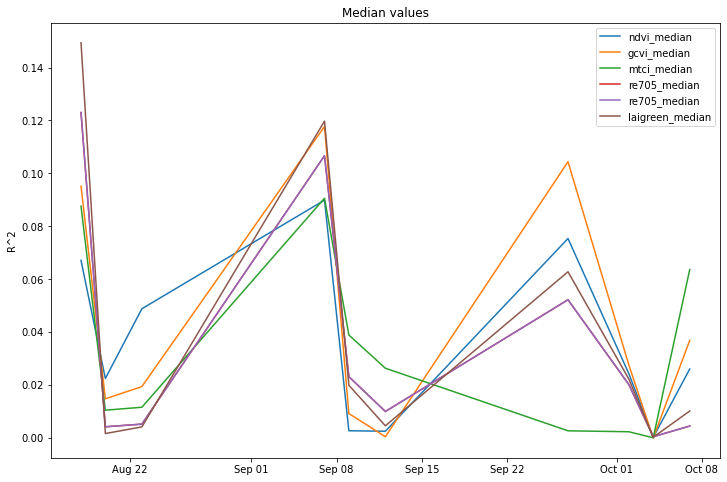

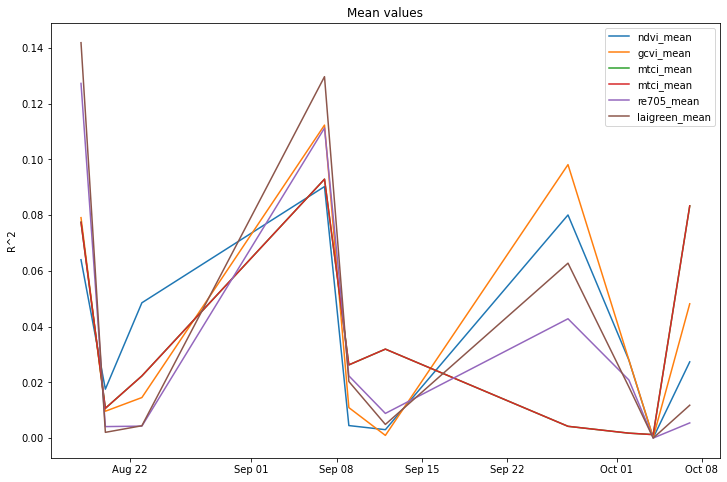

In [5]:
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


df_r2_maize = pd.DataFrame(columns=['date', 'ndvi_median', 'ndvi_mean', 'gcvi_median', 'gcvi_mean',
                                   'mtci_median', 'mtci_mean', 're705_median', 'mtci_mean',
                                   're705_median', 're705_mean', 'laigreen_median', 'laigreen_mean'])

i = 0
for date in df.date.unique():
    temp = df[df['date'] == date]
    temp = temp[temp['crop1'] == 'maize']
    df_r2_maize = df_r2_maize.append(pd.Series(), ignore_index=True)
    df_r2_maize.iloc[i]['ndvi_median'] = sm.ols(formula="Yield_KgHa ~ ndvi_median", data=temp).fit().rsquared
    df_r2_maize.iloc[i]['ndvi_mean'] = sm.ols(formula="Yield_KgHa ~ ndvi_mean", data=temp).fit().rsquared
    df_r2_maize.iloc[i]['gcvi_median'] = sm.ols(formula="Yield_KgHa ~ gcvi_median", data=temp).fit().rsquared
    df_r2_maize.iloc[i]['gcvi_mean'] = sm.ols(formula="Yield_KgHa ~ gcvi_mean", data=temp).fit().rsquared
    df_r2_maize.iloc[i]['mtci_median'] = sm.ols(formula="Yield_KgHa ~ mtci_median", data=temp).fit().rsquared
    df_r2_maize.iloc[i]['mtci_mean'] = sm.ols(formula="Yield_KgHa ~ mtci_mean", data=temp).fit().rsquared
    df_r2_maize.iloc[i]['re705_median'] = sm.ols(formula="Yield_KgHa ~ re705_median", data=temp).fit().rsquared
    df_r2_maize.iloc[i]['re705_mean'] = sm.ols(formula="Yield_KgHa ~ re705_mean", data=temp).fit().rsquared
    df_r2_maize.iloc[i]['laigreen_median'] = sm.ols(formula="Yield_KgHa ~ laigreen_median", data=temp).fit().rsquared
    df_r2_maize.iloc[i]['laigreen_mean'] = sm.ols(formula="Yield_KgHa ~ laigreen_mean", data=temp).fit().rsquared
    df_r2_maize.iloc[i]['date'] = date
    i += 1


df_r2_maize.index = df_r2_maize['date']
df_r2_maize.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(12, 8))
for x in ['ndvi_median', 'gcvi_median', 'mtci_median', 're705_median', 'laigreen_median']:
    ax.plot(df_r2_maize[x], label=x)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.legend()
    ax.set_ylabel('R^2')
    ax.set_title('Median values')

fig, ax = plt.subplots(figsize=(12, 8))
for x in ['ndvi_mean', 'gcvi_mean', 'mtci_mean', 're705_mean', 'laigreen_mean']:
    ax.plot(df_r2_maize[x], label=x)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.legend()
    ax.set_ylabel('R^2')
    ax.set_title('Mean values')


## Extract maximum value 

The performance of the VIs is quite poor. All dates with a reasonable number of observations have an R^2 of less than 0.05 between the crop cut yield per hectare value and the satellites VIs. Hence, it does not appear that the data and methodology used can in fact measure maize yields reliably in this sample, assuming that the crop cut values and GPS data are accurate. However, we will proceed with the exercise anyways for demonstration purposes. 

Since the data documentation indicates that crops were harvested around the start of October, we will calculate the maximum value of each of the VIs across dates in the earlier range and then compare these to the yield per hectare values for each plot.

In [6]:
filtered = df[df['date'] < datetime.datetime.fromisoformat('2017-10-01')]
filtered = filtered[filtered['crop1'] == 'sorghum']
max_values = filtered.groupby(['id']).max()
sm.ols(formula="Yield_KgHa ~ re705_median", data=max_values).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Yield_KgHa   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     12.69
Date:                Sun, 12 Jul 2020   Prob (F-statistic):           0.000528
Time:                        22:01:03   Log-Likelihood:                -862.29
No. Observations:                 123   AIC:                             1729.
Df Residuals:                     121   BIC:                             1734.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       45.9404    113.669      0.404      0.687    -179.097     270.977
re705_median  1025.5698    287.935      3.562      0.001     455.526    1595.614
==============================================================================
Omnibus:                        4.804   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                4.855
Skew:                           0.479   Prob(JB):                       0.0883
Kurtosis:                       2.824   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

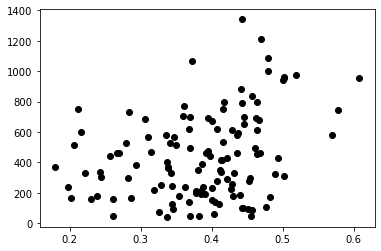

In [7]:
plt.plot(max_values['re705_median'], max_values['Yield_KgHa'], 'o', color='black')

The reNDVI measurement is now at least moderately correlated with the crop cut data. In practice, we would aim for much more consistency between the satellite values and ground truth data.

In the final notebook, we will recreate the analysis from notebooks 1 and 2 using the Google Earth Engine.